# VA Passenger Availability SLA Report

Once the upgrade to Linux has been completed it is measured using an automated script on the server measuring the availability of the Passenger Service by checking & logging the availability of the SSID (WLAN) and the software health after the booting phase. The System Uptime and hence the Expected Operation Time starts after the booting phase of the software initiated by power on. Any time the Passenger Service then is not available is considered an Unplanned Downtime.

## Open tasks
- [ ] add/improve description (Why? What? How?)
- [x] make consideration of DRM Widevine/Fairplay, Moving Map, Analytics Receiver optional and configurable in the report
- [ ] set first appcheck (timestamp) as the start of operation time and power off as the end
- [ ] consider CWAP unavailabilities by counting Errors as unavailability
- [ ] sum up the 10 minute periods of a failed app check to unavailability time
- [ ] structure the code and, for instance, use functions
- [ ] implement Kibana API interface
- [ ] come up with a CI/CD workflow for this/publish the Jupyter report

In [7]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Read the log data

## Source of information
The data, that the Juypter Notebook processes and bases the report on, comes from **BoardConnect Kibana Prod**.


Since the Notebook currently does not have a direct interface to Kibana implemented, we need to request the data
in Kibana and export it as a **CSV** file.

In Kibana, one fine a stored request which is named **VAPaxAvailSLAv2** and which should be executed using the
relevant timeframe that should be considered in the report (for instance: November 2021).

In a first step, the CSV file needs to be provided to Juypter Notebook, so that it can be read and processed.

In [8]:
# read csv (VAPaxAvailSLAv2) into dataframe
df = pd.read_csv('/Users/u293733/git.jupyter-notebooks/VAPaxAvailSLAv2.csv')
# outlign the shape 
df.shape


(42774, 12)

# Data adjustments

We keep the original data in the dataframe df and create a copy of it for further processing.  
In this copy we adjust the data so that it becomes - for instance - better readable.

## Transfer Event Ids

In the original dataset, the events which had been logged, are stored as numbers.  
We convert these numbers to humanly readable event descriptions. 

|Event ID | Event name|
|--------|--------|
|10891+ | CWAP health |
|10900+ | CWAP status |
|30100 | AppCheck |
|10811 | Weight on wheels |
|10812 | Weight off wheels |

In [9]:
# create new dataframe from df and add column EventID
df_new = df.copy()
# map the eventID to readable event names
eventId_map = {'eventId': {10891: 'CWAP health', 10892: 'CWAP health', 10893: 'CWAP health', 10894: 'CWAP health', 
                        10900: 'CWAP status', 10901: 'CWAP status', 10902: 'CWAP status', 10903: 'CWAP status',
                        30100: 'AppCheck', 10811: 'Weight on wheels', 10812: 'Weight off wheels', 10957: 'Power on/off'}}
# replace eventId with readable values from the map
df_new.replace(eventId_map, inplace=True)
# in Python, it's a good practice to typecase categorical features to a category type to fasten up the processing of the data
df_new['eventId'] = df_new['eventId'].astype('category')



## Extract grouped data

Some logged data comes as a concatenated string and, for further processing and better interpretation, now needs to be split and stored
in separate fields.

In [10]:
# filter for eventId = 'AppCheck' and create a new column 'FlightNo' with the first element of the split column 'data.element0'
df_new['FlightNo'] = df_new[df_new['eventId'] == 'AppCheck']['data.element0'].str.split(';').str[0]
# filter for eventId = 'CWAP status' and create a new column 'PaxConnected' with the value from 'data.element5'
df_new['PaxConnected'] = df_new[df_new['eventId'] == 'CWAP status']['data.element5']
# filter for eventId = 'AppCheck' and take the fourth element out of 'data.element0'; get the first integer out of it and add this to new column 'PortalFrontendHomepage' (1 = success)
df_new['PortalFrontendHomepage'] = df_new[df_new['eventId'] == 'AppCheck']['data.element0'].str.split(';').str[3].str.split(':').str[1].str.split(',').str[0].astype(int)
# proceed with the other components that are checked by BCEL AppCheck
df_new['PortalFrontendApp'] = df_new[df_new['eventId'] == 'AppCheck']['data.element0'].str.split(';').str[4].str.split(':').str[1].str.split(',').str[0].astype(int)
df_new['PortalRuntime'] = df_new[df_new['eventId'] == 'AppCheck']['data.element0'].str.split(';').str[5].str.split(':').str[1].str.split(',').str[0].astype(int)
df_new['AnalyticsReceiver'] = df_new[df_new['eventId'] == 'AppCheck']['data.element0'].str.split(';').str[6].str.split(':').str[1].str.split(',').str[0].astype(int)
df_new['MovingMap'] = df_new[df_new['eventId'] == 'AppCheck']['data.element0'].str.split(';').str[7].str.split(':').str[1].str.split(',').str[0].astype(int)
df_new['FlightAPI'] = df_new[df_new['eventId'] == 'AppCheck']['data.element0'].str.split(';').str[8].str.split(':').str[1].str.split(',').str[0].astype(int)
df_new['InflightContentServer'] = df_new[df_new['eventId'] == 'AppCheck']['data.element0'].str.split(';').str[9].str.split(':').str[1].str.split(',').str[0].astype(int)
df_new['DRMWidevine'] = df_new[df_new['eventId'] == 'AppCheck']['data.element0'].str.split(';').str[10].str.split(':').str[1].str.split(',').str[0].astype(int)
df_new['DRMFairplay'] = df_new[df_new['eventId'] == 'AppCheck']['data.element0'].str.split(';').str[11].str.split(':').str[1].str.split(',').str[0].astype(int)


## Configuration section

In this section we define the **components** that the Juypter Notebook shall consider for report generation.

**Hint**
> The AppCheck currently considers 9 different components to be mandatorily checked by it.
> These are:
> - Portal Frontend Homepage
> - Portal Frontend App
> - Portal Runtime
> - Analytics Receiver
> - Moving Map
> - Flight API
> - Inflight Content Server
> - DRM Widevine
> - DRM Fairplay

As per an agreement with the VA PDM from Dec, 2nd 2021, we consider the following components as relevant for measuring the BC IFE service availability:

> - Portal Frontend Homepage
> - Portal Frontend App
> - Portal Runtime
> - Flight API
> - Inflight Content Server

In [11]:
# create a list of components for the diagram; we leave out the non-SLA-relevant components and combine PortalFrontendHomepage and PortalFrontendApp 
#components = ['PortalFrontendHomepage', 'PortalFrontendApp', 'PortalRuntime', 'AnalyticsReceiver', 'MovingMap', 'FlightAPI', 'InflightContentServer', 'DRMWidevine', 'DRMFairplay']
components = ['PortalFrontendHomepage', 'PortalFrontendApp', 'PortalRuntime', 'FlightAPI', 'InflightContentServer']
# create a list of all servers in the report 
servers = list()
for s in df_new['serialNumber'].unique().tolist():
    servers.append(s)
# if other servers (or a subset of servers) than contained in the CSV file shall be used, append those explicitly to the list
#servers.append('7CTCA20586')

# Report visualisation (optional)

## Stacked bar chart of succeeded and failed appchecks per component and server (thus, aircraft)

The subsequent charts show the totals for the succeeded and failed AppChecks on all defined servers in the time period  
that is contained in the CSV file.

(For further visualisations, refer to this)[https://towardsdatascience.com/stacked-bar-charts-with-pythons-matplotlib-f4020e4eb4a7]

Iteration for server 3442310010


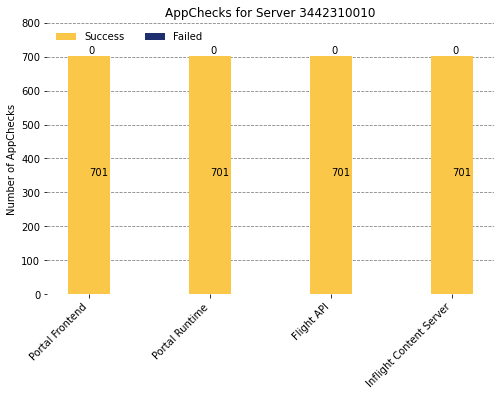

Iteration for server 3467540006


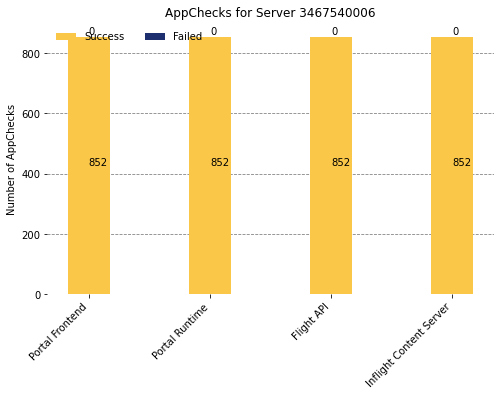

Iteration for server 3352680006


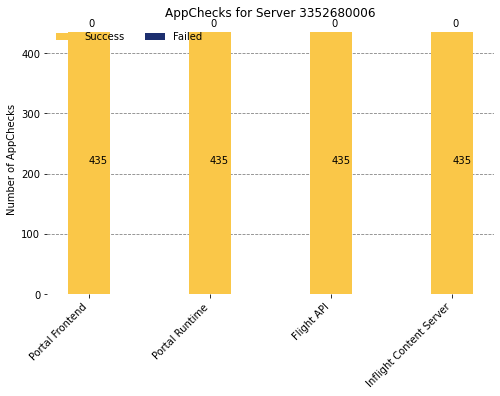

Iteration for server 3395600002


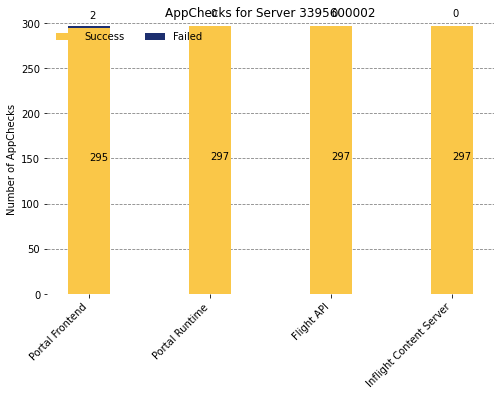

Iteration for server 3734240001


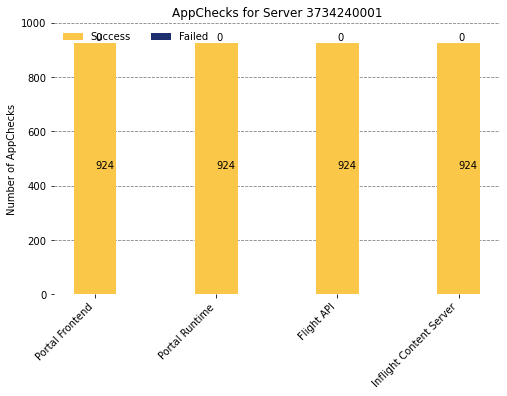

Iteration for server 3413940001


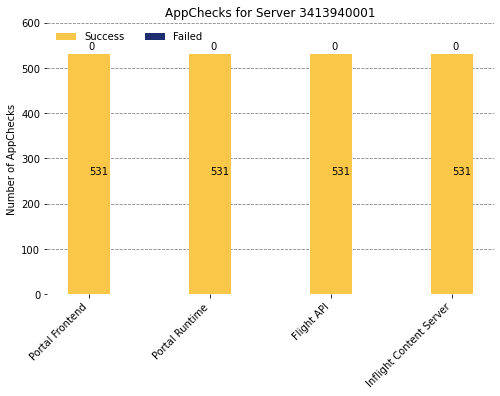

Iteration for server 3472530005


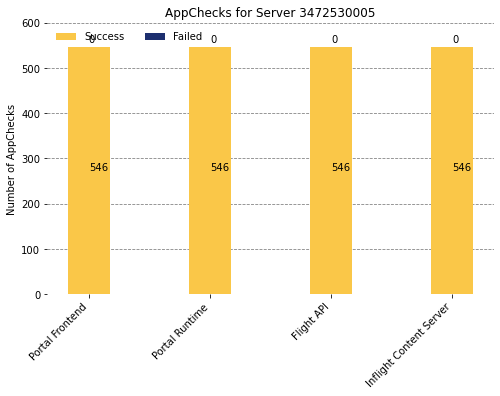

Iteration for server 3413940014
No appchecks for server 3413940014
Iteration for server 7CTCA20586


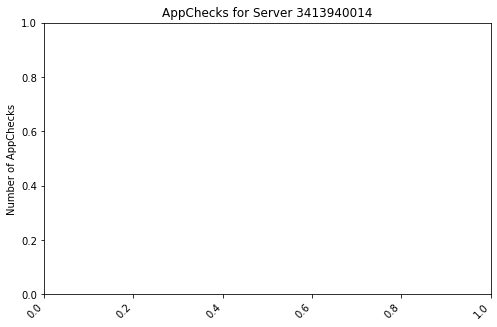

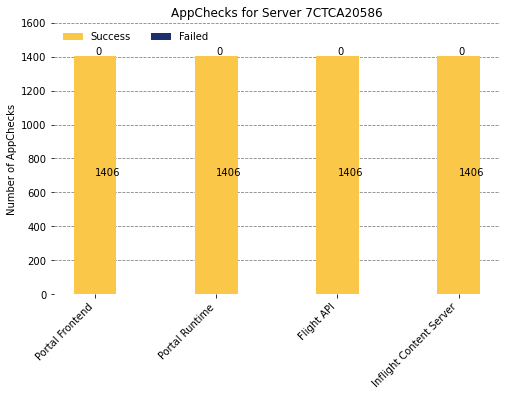

Iteration for server 3413940006


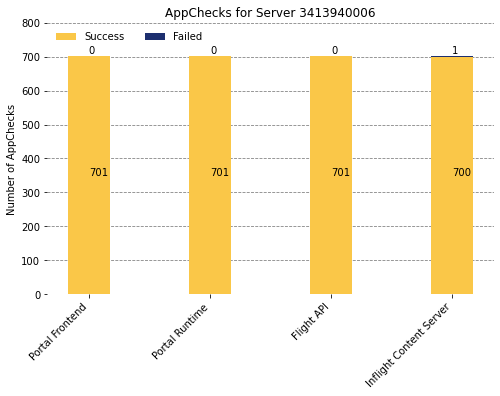

In [16]:
# create a working copy of df_new, filtered by eventId = 'AppCheck', using only the columns: timestamp, serialNumber, eventId, PortalFrontendHomepage
df_work_appcheck = df_new[df_new['eventId'] == 'AppCheck'][['timestamp', 'serialNumber', 'eventId', 'PortalFrontendHomepage', 'PortalFrontendApp', 'PortalRuntime', 'AnalyticsReceiver', 'MovingMap', 'FlightAPI', 'InflightContentServer', 'DRMWidevine', 'DRMFairplay']]
# define the labels to be used in the charts
labels = ['Portal Frontend', 'Portal Runtime', 'Flight API', 'Inflight Content Server']
# i is just a counter to print the respective dataframe df_list[i]
i = 0
# start defining the stacked bar plot
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748']
width = 0.35
#iterate over all servers and create a new dataframe for each server and component which contains the numbers of succeeded and failed component checks; store these new dataframes in df_list()
for s in servers:
    print('Iteration for server ' + str(s))
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_ylabel('Number of AppChecks')
    plt.xticks(
        rotation=45,
        horizontalalignment='right',
        fontweight='light',
        fontsize='medium',
    )
    # chart's title
    ax.set_title('AppChecks for Server ' + str(s))
    # suc is the series of successful appchecks for the current server and and the respective component
    suc = pd.Series(dtype = 'object')
    # fail is the series of failed appchecks for the current server and respective component
    fail = pd.Series(dtype = 'object')
    # create a list of dataframes
    df_list = list()
    # first, define a filter for all servers in list s
    df_server_filter = (df_new['serialNumber'] == s)
    # then, iterate over the labels (which are components of the appcheck) and create a dataframe per server and component
    for component in components:
        # reset the dataframe per server
        df_component = ()
        # define the components as categorical data using value 1, 0 (1 = success, 0 = failure)
        df_work_appcheck[component] = pd.Categorical(df_work_appcheck[component], categories=[1, 0], ordered=True)
        # create a new series for each component by grouping the filtered original dataframe by the component and count the number of occurences
        df_component = df_work_appcheck.loc[df_server_filter, :].groupby([component])[component].count()
        df_component = df_component.to_frame()
        # append df_component.loc[1] to suc; suc now contains the number of successful appchecks for the current server and respective component
        suc = suc.append(df_component.loc[1])
        # append df_component.loc[0] to fail; fail now contains the number of failed appchecks for the current server and respective component
        fail = fail.append(df_component.loc[0])
        df_list.append(df_component)
        i += 1

    #we don't want to differentiate Portal Frontend Homepage and Portal Frontend App but consolidate them as Portal Frontend in the report
    if suc.PortalFrontendApp < suc.PortalFrontendHomepage: 
        # drop suc.PortalFrontendHomepage
        suc = suc.drop(suc.index[suc.index == 'PortalFrontendHomepage'])
        fail = fail.drop(fail.index[fail.index == 'PortalFrontendHomepage'])
    else:
        # drop suc.PortalFrontendApp
        suc = suc.drop(suc.index[suc.index == 'PortalFrontendApp'])
        fail = fail.drop(fail.index[fail.index == 'PortalFrontendApp'])
    # create a matplotlib ax.bar with labels and the data from the list of dataframes
    if (suc.sum(axis=0) > 0 or fail.sum(axis=0) > 0): 
        ax.bar(labels, suc.to_list(), width, color=colors[3], label='Suceeded')
        ax.bar(labels, fail.to_list(), width, bottom=suc.to_list(), color=colors[0], label='Failed')
        for index,data in enumerate(suc.to_list()):
            plt.text(x=index , y =data/2 , s=f"{data}" , fontdict=dict(fontsize=10))
        for index,data in enumerate(fail.to_list()):
            plt.text(x=index , y =suc.to_list()[index]+10 , s=f"{data}" , fontdict=dict(fontsize=10))
        # remove spines
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        # adjust limits and draw grid lines
        plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='gray', linestyle='dashed')
        # legend
        plt.legend(['Success', 'Failed'], loc='upper left', ncol=4, frameon=False)
        plt.show()
    else:
        print('No appchecks for server ' + str(s))
        continue



## Tabular overview of the events per server

What I need:
- Event 30100 = AppCheck: ['FlightNo'], info whether (at least) one of the appchecks failed
- Event 10900-10903: CWAP status (BITE Status:"%1"; Internal Power Status:"%2"; SSID Status:"%3"; Uptime:data.element3; Clients Connected:"%5"; Clients on 2.4 GHz: data.element5; Clients on 5 GHz:data.element6;  )
- Event 10891-10894: CWAP health: data.element4 <Activated|Error>
- Event 10957: Last PowerOn/Off (data.element0 = Power on, data.element1 = Power off)
- 

In [18]:
# create a new working df and only copy the columns we need
#df_work_events = df_new[['timestamp', 'serialNumber', 'eventId', 'data.element0', 'data.element1', 'data.element2', 'data.element3', 'data.element4', 'data.element5', 'data.element6', 'FlightNo']]
df_work_events = df_new.copy()
# hey, let's make column 'timestamp' really a timestamp and use it as index
df_work_events['timestamp'] = pd.to_datetime(df_work_events['timestamp'], format='%b %d, %Y @ %H:%M:%S.%f')
#df_work_events.set_index('timestamp', inplace=True)

# iterate over all servers in list servers
for s in servers:
    print('Iteration for server ' + str(s))
    filter_server = (df_work_events['serialNumber'] == s)
    # filter_power_on is furthermore used to filter all Power on/off events as well as Weight on/off wheels to be able to show operation times between those events
    # if operation time should be aggregated on a higher level, Weight on/off wheels events are not relevant and can be left out
    filter_power_on = (df_work_events['eventId'] == 'Power on/off')
    #filter_power_on = (df_work_events['eventId'] == 'Power on/off') | (df_work_events['eventId'] == 'Weight off wheels') | (df_work_events['eventId'] == 'Weight on wheels')
    filter = (filter_server) & (filter_power_on)
    # define a temporary dataframe for each server, on which we perform date-based selections
    df_temp = df_work_events.loc[filter_server, :]
    # define a pd Series that will store all timestamps when event 'Power on/off' was logged on this server
    power_timestamps = pd.Series(dtype='object');
    # create a series for each server with the timestamp of match for eventId = 'Power on/off'
    power_timestamps = df_temp[filter_power_on]['timestamp']
    # make timestamp the index, so that we can localise certain rows easily
    df_temp.set_index('timestamp', inplace=True)
    # create a new dataframe df_sla with timestamp as index and the columns: event, timestamp, cwap, appcheck, availability 
    df_sla = pd.DataFrame(columns=['event', 'poweron', 'poweroff', 'timestamp', 'cwap', 'client connected', 'appcheck', 'availability', 'powercycle'])
    # fill the dataframe with the values from the series
    # first, fill in when Power on/off occured
    df_sla['event'] = df_work_events[filter]['eventId']
    df_sla['timestamp'] = power_timestamps
    # data.element0 contains the power on timestamp and data.element1 contains the power off timestamp
    df_sla['poweron'] = df_work_events[filter]['data.element0']
    df_sla['poweroff'] = df_work_events[filter]['data.element1']
    df_sla['poweron'] = pd.to_datetime(df_sla['poweron'])
    df_sla['poweroff'] = pd.to_datetime(df_sla['poweroff'])
    # second, from df_work_events filter all events 'CWAP status' between two power cycles and fill in the dataframe
    # iterate over the pairs of elements of the series power_timestamps (thus, the period between two power cycles)
    for (index, ts) in enumerate(power_timestamps):
        if index < len(power_timestamps.to_list()) - 1:
            # get the current timestamp (start powercycle) and the next timestamp (end powercycle) to then filter all events in this power cycle
            current_ts = ts
            next_ts = power_timestamps.to_list()[index + 1]
            #from df_temp slice all rows between current_ts and next_ts to be able to get all events for one power cycle
            df_temp_slice = df_temp.loc[current_ts:next_ts, :]
            # make columns data.element5 and data.element6 from df_temp_slice integers and ignore NaN values
            df_temp_slice['data.element5'] = pd.to_numeric(df_temp_slice['data.element5'], errors='coerce')
            df_temp_slice['data.element6'] = pd.to_numeric(df_temp_slice['data.element6'], errors='coerce')
            # collect and fill in the connected pax for this power cycle
            # define a list of columns in which connected pax numbers are stored
            pax_connected_list = ['data.element5', 'data.element6']
            # sum up the values from columns ['data.element5', 'data.element6'] in df_temp_slice, where eventId = 'CWAP status'
            pax_connected = df_temp_slice.loc[df_temp_slice['eventId'] == 'CWAP status', pax_connected_list].sum(axis=1)
            # if pax_connected isn't empty and the sum of axis=1 is not 0, then fill in the value
            if not pax_connected.empty and pax_connected.sum(axis=0) != 0:
                df_sla.loc[df_sla.timestamp == current_ts, 'client connected'] =  pax_connected.sum(axis=0)
            else:
                df_sla.loc[df_sla.timestamp == current_ts, 'client connected'] =  0
            # in the next step, aggregate the status of the appcheck for this power cycle
            # all components (frontend, runtime etc.) need to be mandatorily considered for the appcheck
            # for an aggregated appcheck status, we sum up the values of the columns ['data.element2', 'data.element3', 'data.element4', 'data.element7', 'data.element8', 'data.element9'] in a power cycle from df_temp_slice
            # define a list of columns in which appcheck status is stored
            appcheck_list = ['PortalFrontendHomepage', 'PortalFrontendApp', 'PortalRuntime', 'AnalyticsReceiver', 'MovingMap', 'FlightAPI', 'InflightContentServer', 'DRMWidevine', 'DRMFairplay']
            # sum up the values from columns in appchecklist; thus, this is the number of succeeded appchecks per appcheck in this power cycle
            appcheck_succeeded = df_temp_slice.loc[df_temp_slice['eventId'] == 'AppCheck', appcheck_list].sum(axis=1)
            # define appchecks as the number of rows from df_temp_slice where eventId = 'AppCheck'; i.e. appchecks is the number of appchecks in this power cycle
            appchecks = df_temp_slice.loc[df_temp_slice['eventId'] == 'AppCheck'].shape[0]
            # the overall number of appchecks succeded in this powercycle
            sum_appcheck_succeeded = appcheck_succeeded.sum(axis=0)
            # avail is the number of succeeded appchecks divided by the number of appchecks (multiplied by number of components) multiplied by 100
            avail = (sum_appcheck_succeeded / (appchecks * 9)) * 100
            df_sla.loc[df_sla.timestamp == current_ts, 'appcheck'] =  sum_appcheck_succeeded
            df_sla.loc[df_sla.timestamp == current_ts, 'availability'] =  avail
            # finally, aggregate the cwap health status for this power cycle
            # define a list of columns in which cwap status is stored
            cwap_list = ['data.element3', 'data.element4']
            # sum up the values from columns in cwap_list, where eventId = 'CWAP health'
            cwap_health_filter = (df_temp_slice['eventId'] == 'CWAP health') & (df_temp_slice['data.element3'] == 'Error')
            # sum up the values from columns in cwap_list, where eventId = 'CWAP health'
            cwap = df_temp_slice.loc[cwap_health_filter, cwap_list].count(axis=1)
            if not cwap.empty and cwap.sum(axis=0) != 0:
                df_sla.loc[df_sla.timestamp == current_ts, 'cwap'] =  'Error'
            else:
                df_sla.loc[df_sla.timestamp == current_ts, 'cwap'] =  'Activated'
            # last but not least, fill in the powercycle column; it's the time difference between the poweron and poweroff of the current powercycle
            # if poweron is not empty or NaN and poweroff is not empty or NaN, then fill in the value
            power_on = df_sla.loc[df_sla.timestamp == current_ts, 'poweron'].count()
            power_off = df_sla.loc[df_sla.timestamp == current_ts, 'poweroff'].count()
            if (power_on > 0) and (power_off > 0):
                df_sla.loc[df_sla.timestamp == current_ts, 'powercycle'] =  df_sla.loc[df_sla.timestamp == current_ts, 'poweroff'] - df_sla.loc[df_sla.timestamp == current_ts, 'poweron']
            df_sla['powercycle'] = pd.to_timedelta(df_sla['powercycle'],'h')
            df_sla['ops time'] = df_sla.poweron - df_sla.poweroff
            #df_sla['powercycle'] = df_sla['powercycle']/np.timedelta64(1,'h')

        # remember, the index of series power_timestamps is the same as in df_work_events
    df_sla.set_index('timestamp', inplace=True)
    df_sla.to_markdown('sla_' + str(s) + '.md')
""" pd.options.display.max_columns = None
pd.options.display.max_rows = None
df_sla.style
df_sla
 """
    #








Iteration for server 3442310010


/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  power_timestamps = df_temp[filter_power_on]['timestamp']
/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_slice['data.element5'] = pd.to_numeric(df_temp_slice['data.element5'], errors='coerce')
/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

Iteration for server 3467540006


/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_slice['data.element6'] = pd.to_numeric(df_temp_slice['data.element6'], errors='coerce')
/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_slice['data.element5'] = pd.to_numeric(df_temp_slice['data.element5'], errors='coerce')
/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_430

Iteration for server 3352680006


/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_slice['data.element6'] = pd.to_numeric(df_temp_slice['data.element6'], errors='coerce')
/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_slice['data.element5'] = pd.to_numeric(df_temp_slice['data.element5'], errors='coerce')
/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_430

Iteration for server 3395600002


/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_slice['data.element6'] = pd.to_numeric(df_temp_slice['data.element6'], errors='coerce')
/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_slice['data.element5'] = pd.to_numeric(df_temp_slice['data.element5'], errors='coerce')
/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_430

Iteration for server 3734240001


/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_slice['data.element5'] = pd.to_numeric(df_temp_slice['data.element5'], errors='coerce')
/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_slice['data.element6'] = pd.to_numeric(df_temp_slice['data.element6'], errors='coerce')
/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_430

Iteration for server 3413940001


/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_slice['data.element5'] = pd.to_numeric(df_temp_slice['data.element5'], errors='coerce')
/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_slice['data.element6'] = pd.to_numeric(df_temp_slice['data.element6'], errors='coerce')
/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_430

Iteration for server 3472530005


/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_slice['data.element6'] = pd.to_numeric(df_temp_slice['data.element6'], errors='coerce')
/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_slice['data.element5'] = pd.to_numeric(df_temp_slice['data.element5'], errors='coerce')
/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_430

Iteration for server 3413940014
Iteration for server 7CTCA20586
Iteration for server 3413940006


/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_slice['data.element5'] = pd.to_numeric(df_temp_slice['data.element5'], errors='coerce')
/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_43055/4050235351.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_slice['data.element6'] = pd.to_numeric(df_temp_slice['data.element6'], errors='coerce')
/var/folders/yt/g3pjgfp12l913d500hlnzffc0000gn/T/ipykernel_430

' pd.options.display.max_columns = None\npd.options.display.max_rows = None\ndf_sla.style\ndf_sla\n '